# Clustering Assignment

### Business Objective

HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. 

After the recent funding programmes, they have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid. 

#### Import libraries

In [82]:
#Import necessary libraries

#Basic Libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('max.colwidth',-1)
from collections import Counter

#Plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Model building and processing libraries
import statsmodels.api as sm

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

#For calculating Hopkins Score
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

In [83]:
#Read the data
df = pd.read_csv('Country-data.csv')

#Print first five rows
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [84]:
#Inspect the dataframe 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [85]:
#Make a deep copy of socio ecomnomical data so that changes can be done on the copy leaving the original data frame as is
df_socio_eco = df.copy(deep=True)

In [86]:
#Give the columns easy to read names
df_socio_eco.columns = ['Country', 'ChildMortality', 'ExportsPerCap', 'HealthPerCap', 'ImportsPerCap', 'Income',
       'Inflation', 'LifeExpectancy', 'TotalFert', 'GDPPerCap']


#### Convert Export, Import and Health per capita to actuals

In [87]:
#Convert Exports, Imports and Helth Per Capita to actual values as they are represented as percent of GDP Per Capita
cols=['ExportsPerCap', 'HealthPerCap', 'ImportsPerCap']
df_socio_eco[cols] = df_socio_eco[cols].apply(lambda x : x*df_socio_eco['GDPPerCap']/100)

In [88]:
#Inspect the head afte conversion
df_socio_eco.head()

,Country,ChildMortality,ExportsPerCap,HealthPerCap,ImportsPerCap,Income,Inflation,LifeExpectancy,TotalFert,GDPPerCap
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


## 1. Data Understanding

### 1.1 Data Cleaning

### 1.1.1 Missing Values

In [89]:
#Print sum of null values present in data - column wise
df_socio_eco.isnull().sum()

Country           0
ChildMortality    0
ExportsPerCap     0
HealthPerCap      0
ImportsPerCap     0
Income            0
Inflation         0
LifeExpectancy    0
TotalFert         0
GDPPerCap         0
dtype: int64

 #### There are no null values present in data. Data Seems to be in good shape with respect to nulls.

### 1.1.2 Outlier Analysis

In [90]:
#Describe statistics to get a feel of outliers
df_socio_eco.describe()

,ChildMortality,ExportsPerCap,HealthPerCap,ImportsPerCap,Income,Inflation,LifeExpectancy,TotalFert,GDPPerCap
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


#### By looking at statistics, there seems to be outliers present in some columns. Inspect them further

In [91]:
#Get the list of numeric columns
num_cols = df_socio_eco.select_dtypes(include=np.number).columns
num_cols

Index(['ChildMortality', 'ExportsPerCap', 'HealthPerCap', 'ImportsPerCap',
       'Income', 'Inflation', 'LifeExpectancy', 'TotalFert', 'GDPPerCap'],
      dtype='object')

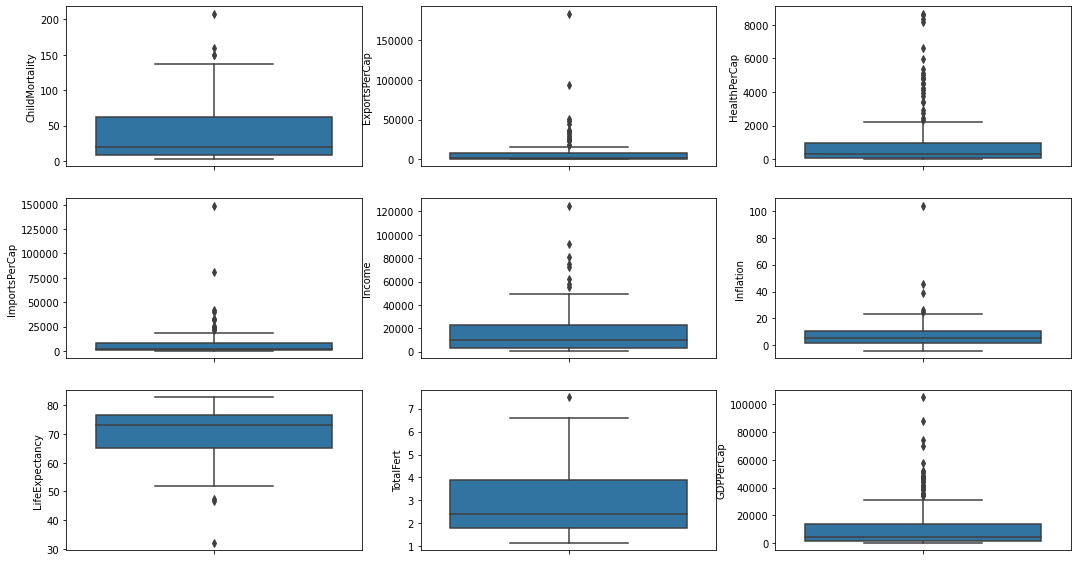

In [92]:
#Draw one dimensional box plots for all numerical columns 
plt.figure(figsize=(18,10))
r=3
c=3
i=1

#Iterate through all columns to draw box plots
for col in num_cols:
    plt.subplot(r,c,i)
    sns.boxplot(y=df_socio_eco[col])
    i +=1

#### Most of the columns have outliers

### Inspect Outliers

In [93]:
#List of Outlier Columns for which we dig deeper
col_outliers = ['ChildMortality','ExportsPerCap',
                'Income','GDPPerCap','Inflation']

#Store quantiles of outliers
quantiles = df_socio_eco.quantile([.01,.05, .1,.25,.5,.75,.9,.95, .99,.999, 1])[col_outliers]
quantiles

,ChildMortality,ExportsPerCap,Income,GDPPerCap,Inflation
0.010,2.800,22.243716,742.24,331.62,-2.3488
0.050,3.460,70.468800,1213.00,465.90,0.1834
0.100,4.200,110.224800,1524.00,593.80,0.5878
0.250,8.250,447.140000,3355.00,1330.00,1.8100
0.500,19.300,1777.440000,9960.00,4660.00,5.3900
0.750,62.100,7278.000000,22800.00,14050.00,10.7500
0.900,100.220,17760.600000,41220.00,41840.00,16.6400
0.950,116.000,31385.100000,48290.00,48610.00,20.8700
0.990,153.400,64794.260000,84374.00,79088.00,41.4780
0.999,200.032,168718.700000,119472.20,102144.80,94.3554


### Plot Top outliers

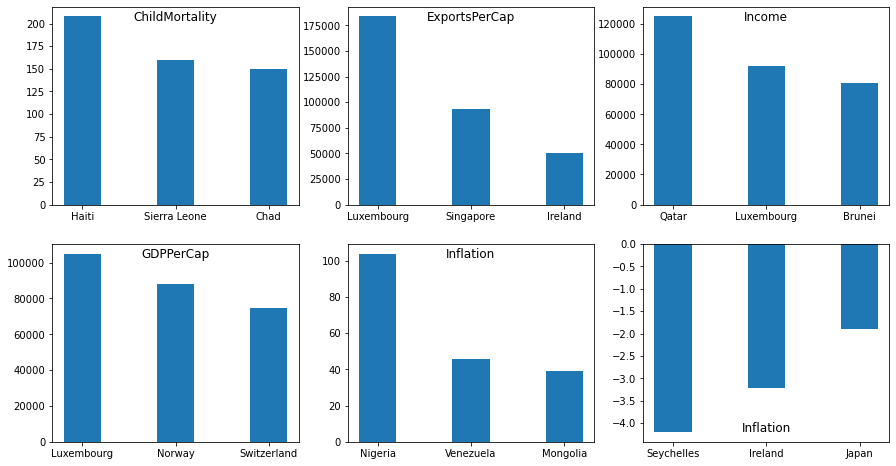

In [94]:
#Plot top 3 outliers (above .95 quantile) on the upper side for the chosen columns 
# Columns -Child Mortality, Exports Per Capita, Imports Per Capita, Income, Inflation and GDP Per Capita variables
plt.figure(figsize=(15,8))
i=1

#Iterate through columns for which we want to show top outliers
for col in col_outliers:
    plt.subplot(2,3,i)
    data = df_socio_eco[df_socio_eco[col] 
                        > quantiles.loc[0.950][col]].sort_values(by=col,ascending=False)[['Country',col]].head(3)
    plt.bar(data['Country'],data[col],width=0.4)
    plt.title(col, x=0.5, y=0.9)
    i +=1

#Just for Inflation column, plot outliers on the lower side (below .01 quantile) as it has outliers on the loser side too 
col = 'Inflation'
plt.subplot(2,3,i)
data = df_socio_eco[df_socio_eco[col] 
                    < quantiles.loc[0.05][col]].sort_values(by=col,ascending=True)[['Country',col]].head(3)
plt.bar(data['Country'],data[col],width=0.4)
plt.title(col, x=0.5, y=0.02)
plt.show()

### Observations on Outliers

#### Child Mortality
There are few countries like Haiti, Sierra Leone and Chad with very high mortality rate.

#### Exports Per Capita
Luxemberg, Singapore and Ireland along with few more countries have higher exports and imports per capita.


#### Income
Qatar and Luxemberg along with other countries have very high income.

#### GDP Per Capita
Luxemberg and Norway along with few more countries have good GDP per capita.

#### inflation
Nizeria and Venezuela have an abnormal rate of inflation. These could be good indicators to spend funds.

Interestingly, few countries have negative inflation. Seychells is on top of this list with a negative inflation rate of 4.2. Their value of money goes up. How nice it is? :)


### Summary of Outliers

#### There are outliers in most of the columns. However, they give us key information about countries that are very poor/rich/developed/backward. Hence do not drop them, just cap them to .95 and .05 quantile values

### Cap Outliers

In [95]:
#Cap upper outliers to .95 quantile value for all columns
for col in num_cols:
    df_socio_eco[col][df_socio_eco[col] >= df_socio_eco[col].quantile(0.95)] = df_socio_eco[col].quantile(0.95)

#Cap lowe outliers to .05 quantile for all columns
for col in num_cols:
    df_socio_eco[col][df_socio_eco[col] <= df_socio_eco[col].quantile(0.05)] = df_socio_eco[col].quantile(0.05)

### Check Outliers after capping

In [96]:
#Store quantiles of outliers
quantiles = df_socio_eco.quantile([.01,.1,.25,.5,.75,.9,.95, .99,.999, 1])[col_outliers]

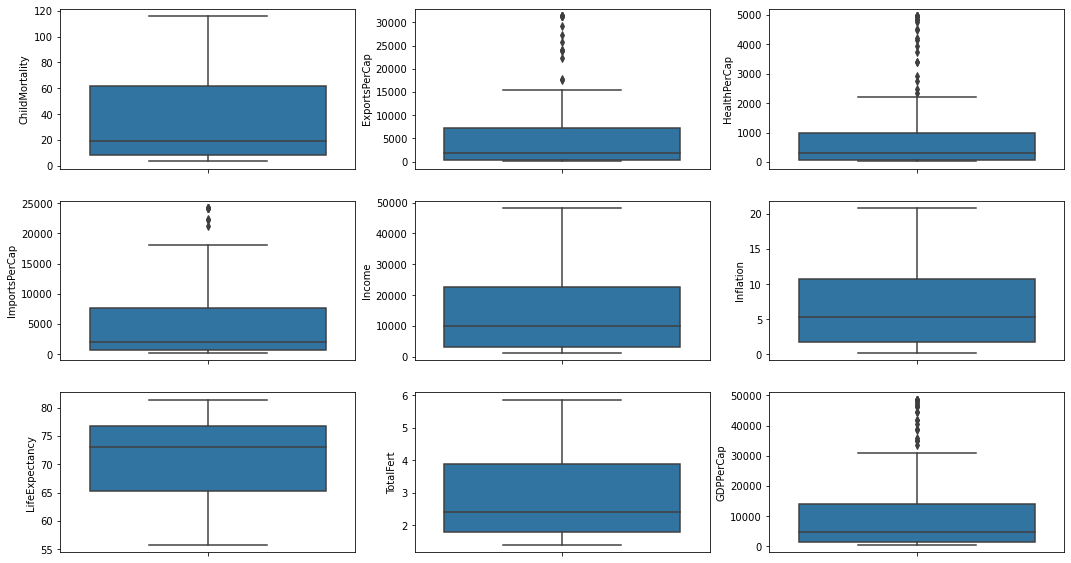

In [97]:
#Draw one dimensional box plots for all numerical columns 
plt.figure(figsize=(18,10))
r=3
c=3
i=1

for col in num_cols:
    plt.subplot(r,c,i)
    sns.boxplot(y=df_socio_eco[col])
    i +=1

#### Most of the outliers are gone. There are still few, but are closer 3rd quartile, hence it is okay to keep them. These will also help us in dividing data into clusters

### 1.1.3 Duplicates

In [98]:
#Print Duplicate rows if any
df_socio_eco[df_socio_eco.duplicated()]

,Country,ChildMortality,ExportsPerCap,HealthPerCap,ImportsPerCap,Income,Inflation,LifeExpectancy,TotalFert,GDPPerCap


#### There are no dupliucates in the dataset. Hence no action to be taken.

### 1.1.4 Data Types

In [99]:
#Print dataframe info to check types
df_socio_eco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
Country           167 non-null object
ChildMortality    167 non-null float64
ExportsPerCap     167 non-null float64
HealthPerCap      167 non-null float64
ImportsPerCap     167 non-null float64
Income            167 non-null float64
Inflation         167 non-null float64
LifeExpectancy    167 non-null float64
TotalFert         167 non-null float64
GDPPerCap         167 non-null float64
dtypes: float64(9), object(1)
memory usage: 13.2+ KB


#### All data types are as expected. Except for country, all are numeric types which is right.

## 1.2 Data Cleaning - Summary

#### Data is now in good shape to procede with next steps. 

1. There are no missing values. 
2. Outliers are capped
3. There are no duplicates
3. Data Types look good as well

## 2. EDA

In [100]:
#Print the first five rows
df_socio_eco.head()

,Country,ChildMortality,ExportsPerCap,HealthPerCap,ImportsPerCap,Income,Inflation,LifeExpectancy,TotalFert,GDPPerCap
0,Afghanistan,90.2,70.4688,41.9174,248.297,1610.0,9.44,56.2,5.820,553.0
1,Albania,16.6,1145.2000,267.8950,1987.740,9930.0,4.49,76.3,1.650,4090.0
2,Algeria,27.3,1712.6400,185.9820,1400.440,12900.0,16.10,76.5,2.890,4460.0
3,Angola,116.0,2199.1900,100.6050,1514.370,5900.0,20.87,60.1,5.861,3530.0
4,Antigua and Barbuda,10.3,5551.0000,735.6600,7185.800,19100.0,1.44,76.8,2.130,12200.0


### 2.1 Univariate Analysis - Distribution of Data

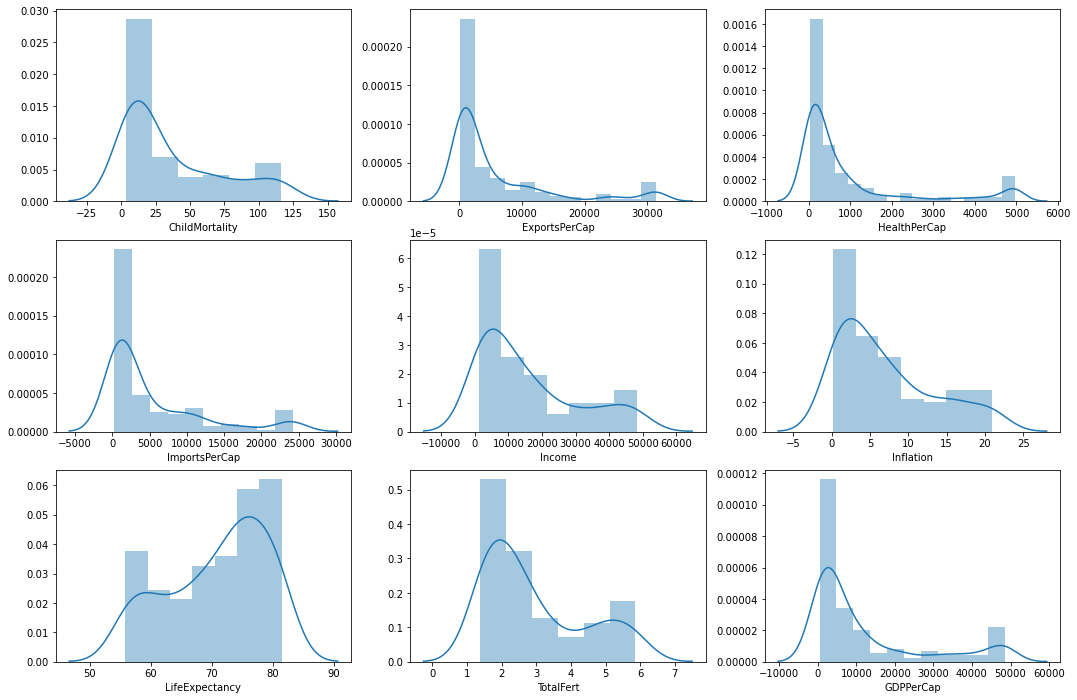

In [101]:
#Draw distributioins for all numerical columns 
plt.figure(figsize=(18,12))
r=3
c=3
i=1

for col in num_cols:
    plt.subplot(r,c,i)
    sns.distplot(df_socio_eco[col])
    i +=1

#### Observations
1. Except for Life Expectancy, data is skewed to the right for all variables. It indicates that few countries have high Income and GDPP. They are developed countries .
2. Some countries have high Child Mortality and Inflation. They are backward countrioes.
2. Life Expectancy is skewed left, which indicates there are few countries with very low life expectancy. This is an indication for not developed countries. 

### 2.2 Bivariate Analysis - Correlations

In [102]:
#Get correlation matrix to draw heatmap
corr = df_socio_eco.corr()
corr

,ChildMortality,ExportsPerCap,HealthPerCap,ImportsPerCap,Income,Inflation,LifeExpectancy,TotalFert,GDPPerCap
ChildMortality,1.000000,-0.480031,-0.500800,-0.539389,-0.637594,0.325082,-0.890201,0.892782,-0.557912
ExportsPerCap,-0.480031,1.000000,0.763772,0.967762,0.881110,-0.248510,0.582728,-0.440643,0.880736
HealthPerCap,-0.500800,0.763772,1.000000,0.834689,0.821681,-0.392093,0.627544,-0.459678,0.936717
ImportsPerCap,-0.539389,0.967762,0.834689,1.000000,0.878580,-0.361760,0.636451,-0.502098,0.901729
Income,-0.637594,0.881110,0.821681,0.878580,1.000000,-0.234853,0.729253,-0.590654,0.941514
Inflation,0.325082,-0.248510,-0.392093,-0.361760,-0.234853,1.000000,-0.336551,0.368325,-0.332902
LifeExpectancy,-0.890201,0.582728,0.627544,0.636451,0.729253,-0.336551,1.000000,-0.821065,0.681829
TotalFert,0.892782,-0.440643,-0.459678,-0.502098,-0.590654,0.368325,-0.821065,1.000000,-0.508362
GDPPerCap,-0.557912,0.880736,0.936717,0.901729,0.941514,-0.332902,0.681829,-0.508362,1.000000


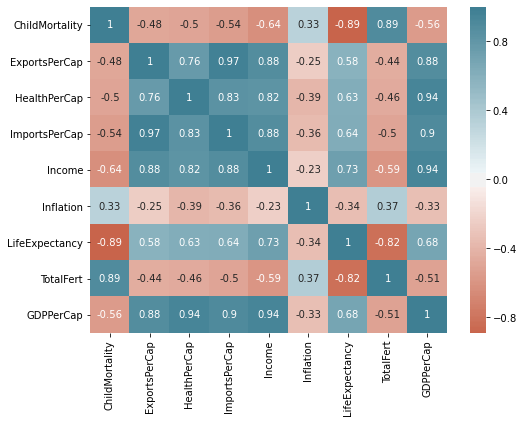

In [103]:
#Draw heat map of correlations
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, center=0, cmap=sns.diverging_palette(20, 220, n=200))

#### GDP Per Capita, Life Expectancy, Child Mortality, Fertility Rate and Income are linearly correlated with some other variables. Draw Pair Plots to see it visualy. 

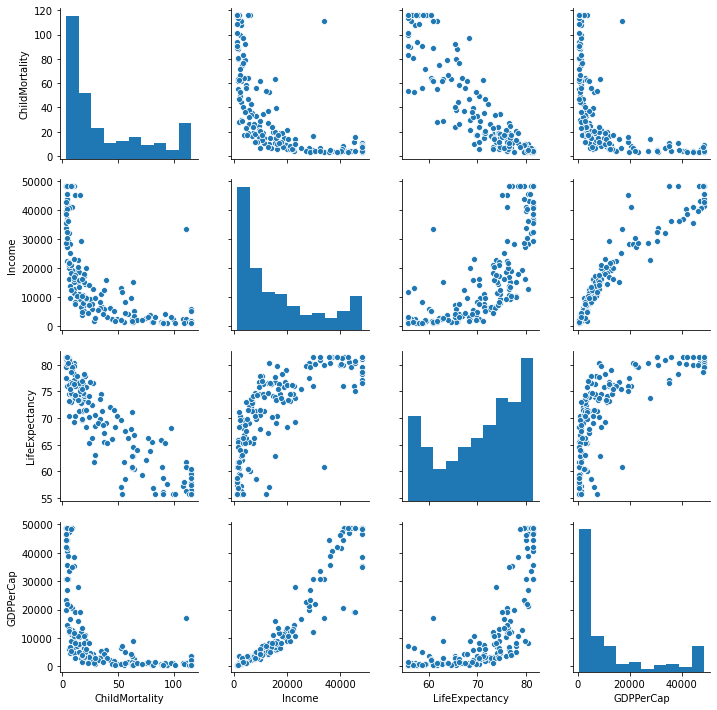

In [104]:
# Draw Scattered pair plots for few columns which seems to have good correlation from heatmap
sns.pairplot(df_socio_eco[['ChildMortality', 'Income', 'LifeExpectancy', 'GDPPerCap']])

#### Observations From Heatmap and Pairplots
1. Life Expectancy and Child Mortality have strong negative correlation. With high Life expectancy, Child Mortality is low which is not surprising.
2. Fertility Rate is Strongly correlated with Child Mortality
3. Interesting to see that, when Fertility rate is more, life expectancy is less.
4. When the income is more, life expectancy is also more. Though this correlation is not very strong.
5. When the GDP Per Capita is more, income is also more, again, not surprising


In [105]:
#Columns to be considered for model. Consider all columns as clustering doesn't assume abbsense of multi collinearity
model_cols = ['ChildMortality', 'ExportsPerCap', 'HealthPerCap', 'ImportsPerCap',
       'Income', 'Inflation', 'LifeExpectancy', 'TotalFert', 'GDPPerCap']

## 3. Data Preparation

### 3.1 Feature Scaling

As we have seen, data for different variables is in widely spread ranges. Bring them all to same scale using StandardScaler. This is important before performing clustering

In [106]:
#Before Scaling, print stats 
df_socio_eco.describe()

,ChildMortality,ExportsPerCap,HealthPerCap,ImportsPerCap,Income,Inflation,LifeExpectancy,TotalFert,GDPPerCap
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,36.808623,5784.478480,954.366191,5142.509689,15755.491018,7.016075,70.830060,2.922389,12003.719162
std,36.193830,8579.136537,1453.198372,6694.383178,14770.353771,6.271398,8.039216,1.438264,15154.443890
min,3.460000,70.468800,26.715920,169.281000,1213.000000,0.183400,55.780000,1.390000,465.900000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,116.000000,31385.100000,4966.701000,24241.560000,48290.000000,20.870000,81.400000,5.861000,48610.000000


In [107]:
#Instantiate Scaler
scaler = MinMaxScaler()

#Make a copy first 
df_socio_eco_scaled = df_socio_eco.copy()

#Fit and Transform numerical data
df_socio_eco_scaled[num_cols] = scaler.fit_transform(df_socio_eco[num_cols].values)

In [108]:
#After Scaling, Inspect Data Frame Info 
df_socio_eco_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
Country           167 non-null object
ChildMortality    167 non-null float64
ExportsPerCap     167 non-null float64
HealthPerCap      167 non-null float64
ImportsPerCap     167 non-null float64
Income            167 non-null float64
Inflation         167 non-null float64
LifeExpectancy    167 non-null float64
TotalFert         167 non-null float64
GDPPerCap         167 non-null float64
dtypes: float64(9), object(1)
memory usage: 13.2+ KB


In [109]:
#After Scaling, print stats 
df_socio_eco_scaled.describe()

,ChildMortality,ExportsPerCap,HealthPerCap,ImportsPerCap,Income,Inflation,LifeExpectancy,TotalFert,GDPPerCap
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,0.296327,0.182471,0.187784,0.206596,0.308909,0.330295,0.587434,0.342740,0.239652
std,0.321609,0.273966,0.294171,0.278095,0.313749,0.303162,0.313787,0.321687,0.314773
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.042563,0.012029,0.010490,0.019563,0.045500,0.078631,0.371585,0.090584,0.017948
50%,0.140750,0.054510,0.059751,0.077944,0.185802,0.251689,0.676034,0.228137,0.087116
75%,0.521059,0.230165,0.192354,0.313652,0.458547,0.510794,0.820453,0.556922,0.282155
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.3 EDA - Univariate - Box Plots

After scaling data, draw box plots to visualize data of all numeric variables on a similar scale 

This section belongs to EDA. However, the data was not scaled at that point. Hence plotting it here.


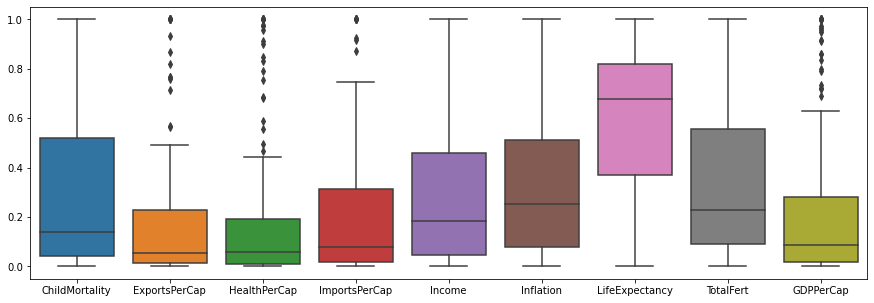

In [110]:
#Box Plots for all numeric variables
plt.figure(figsize=(15,5))
sns.boxplot(data=df_socio_eco_scaled[num_cols])


#### Observations:
1. Data is brought into similar scale. Hence we could visualize all variables reasonably on the same scale
2. Outliers are still present. However, they are not too far from 3rd quarile. 
3. As we have already seen in the distributions, Life Expectancy was the only variable which is left skewed, same can be observed here with lot of values below Q1.

#### Data is in a good format to proceed to modeling now.

## 4. Cluster Tendency - Hopkins Test

In [111]:
## Function to calculate Hopkins Score given a data set of numerical columns
 
def hopkins(X):
    d = X.shape[1]
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [112]:
#Print Hopkins Score
print('Hopkins Score is:', hopkins(df_socio_eco[num_cols]) )

Hopkins Score is: 0.8844562972706594


#### This is a good hopkins score which indicates, the data set has groups in it and clustering can be performed

## 5. Model Building and Evaluation 

### 5.1. KMeans

In [113]:
#Set country as index, so that we can proceed with K-Means which requires all variables to be numeric
df_socio_eco_scaled = df_socio_eco_scaled.set_index('Country')

In [114]:
#Inspect the head of df_socio_eco_scaled after setting index
df_socio_eco_scaled.head()

,ChildMortality,ExportsPerCap,HealthPerCap,ImportsPerCap,Income,Inflation,LifeExpectancy,TotalFert,GDPPerCap
Country,,,,,,,,,
Afghanistan,0.770748,0.000000,0.003077,0.003282,0.008433,0.447468,0.016393,0.990830,0.001809
Albania,0.116758,0.034320,0.048822,0.075542,0.185165,0.208183,0.800937,0.058153,0.075276
Algeria,0.211836,0.052441,0.032240,0.051144,0.248253,0.769416,0.808743,0.335495,0.082961
Angola,1.000000,0.067978,0.014957,0.055877,0.099560,1.000000,0.168618,1.000000,0.063644
Antigua and Barbuda,0.060778,0.175015,0.143511,0.291477,0.379952,0.060745,0.820453,0.165511,0.243729


#### KMeans parameters

In [115]:
#Use the same Random State, number of jobs, initialization type and alogorith  across all runs to get consistent results 
rs, n_init, n_jobs, initialization, algo = 1234, 15, 4, 'k-means++', 'full'

In [116]:
#Instantiate the model with 5 clusters.
kmeans = KMeans(n_clusters=6, init=initialization, random_state=rs, n_init=n_init, n_jobs=n_jobs, algorithm=algo)

#Fit the model
kmeans.fit(df_socio_eco_scaled)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=15, n_jobs=4, precompute_distances='auto',
       random_state=1234, tol=0.0001, verbose=0)

In [117]:
#Print number of countries in each cluster
print(Counter(kmeans.labels_))

Counter({3: 46, 1: 39, 0: 25, 4: 22, 5: 18, 2: 17})


#### We have chosen the number of cluisters as 6 at random, let us find the optimal number of clusters

### 5.1.1 Find Optimal Number of Clusters

#### SSD - Sum Of Squares Distance - Elbow Curve

Text(0.5, 1.0, 'Elbow Curve')

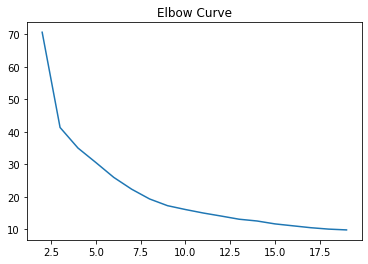

In [118]:
##Initialise SSDs list 
ssd = []

#Check for number of clusters from 2 to 20
n_clusters = range(2,20)

#Run KMeans for each number
for num_clusters in n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init=initialization, random_state=rs, n_init=n_init, n_jobs=n_jobs, algorithm=algo)
    kmeans.fit(df_socio_eco_scaled)
    
    # Append inertia to ssd array
    ssd.append(kmeans.inertia_)
    
#Plot SSDs for each number of clusters
ax = plt.plot(n_clusters, ssd)
plt.title('Elbow Curve')

#### Silhoutte Analysis

In [119]:
#Check for number of clusters from 2 to 20
n_clusters = range(2,20)

#Run KMeans for each number

for num_clusters in n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init=initialization, random_state=rs, n_init=n_init, n_jobs=n_jobs, algorithm=algo)
    kmeans.fit(df_socio_eco_scaled)
    
    cluster_labels = kmeans.labels_
    
    #Silhoutte score
    silhouette_avg = silhouette_score(df_socio_eco_scaled, cluster_labels)
    print('For num_clusters={0}, the silhouette score is {1}'.format(num_clusters, silhouette_avg))


For num_clusters=2, the silhouette score is 0.470600664230014
For num_clusters=3, the silhouette score is 0.42900601259377397
For num_clusters=4, the silhouette score is 0.3157915754680332
For num_clusters=5, the silhouette score is 0.3188140173882563
For num_clusters=6, the silhouette score is 0.2931421105684355
For num_clusters=7, the silhouette score is 0.3343837968776391
For num_clusters=8, the silhouette score is 0.34620142490153283
For num_clusters=9, the silhouette score is 0.3285036440825265
For num_clusters=10, the silhouette score is 0.29879734124946516
For num_clusters=11, the silhouette score is 0.3084692901760469
For num_clusters=12, the silhouette score is 0.2938218174018151
For num_clusters=13, the silhouette score is 0.2975371546717264
For num_clusters=14, the silhouette score is 0.2862322753416887
For num_clusters=15, the silhouette score is 0.28365394634792873
For num_clusters=16, the silhouette score is 0.2801015477474723
For num_clusters=17, the silhouette score is 

#### By looking at Elbow method and silhouette scores, 2 or 3 clusters seem to be optimal number of clusters

In [120]:
#Define a function to Draw Box plots For all clusters against each columns choosen for the model
#It takes the Cluster column name, list of model columns and dataframe as input
def draw_box_clusters(clust_col, cols, df):
    r = 3
    c = 3
    i = 1

    plt.figure(figsize=(18,12))
    
    #Iterate through columns to plot boxes
    for col in cols:
        plt.subplot(r,c,i)
        sns.boxplot(x=clust_col, y=col, data=df)
        i += 1

In [121]:
#Function to Draw Bars with mean value for modeled columns in each cluster  
#It takes the Cluster column name, list of model columns and dataframe as input
def draw_bar_clusters(clust_col, cols, df):
    columns = cols.copy()
    columns.append(clust_col)
    df[columns].groupby(clust_col).mean().plot(kind='bar')

In [122]:
#Function to draw sctter plots on the 3 important columns that we make decision from
#Takes data frame and number of clusters as input
def draw_scatter_clusters(df,k):
    plt.figure(figsize=(15,4))
    
    plt.subplot(1,3,1)
    #GDP Vs Child Mortality
    sns.scatterplot(x='GDPPerCap', y='ChildMortality', data=df, hue='ClusterId', legend='full',
                   palette=sns.color_palette('bright',k))
    
    plt.subplot(1,3,2)
    #Income Vs Child Mortality
    sns.scatterplot(x='Income', y='ChildMortality', data=df, hue='ClusterId', legend='full',
                   palette=sns.color_palette('bright',k))
    
    plt.subplot(1,3,3)
    #GDP vs income
    sns.scatterplot(x='GDPPerCap', y='Income', data=df, hue='ClusterId', legend='full',
                   palette=sns.color_palette('bright',k))

### 5.1.2 Model with 2 clusters

In [123]:
# Model with k = 2 and fit it
k=2

#Instantiate the model
kmeans = KMeans(n_clusters=k, init=initialization, random_state=rs, n_init=n_init, n_jobs=n_jobs, algorithm=algo)

#Fit the model
kmeans.fit(df_socio_eco_scaled)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=15, n_jobs=4, precompute_distances='auto',
       random_state=1234, tol=0.0001, verbose=0)

In [124]:
#Assign Cluster Id to a column
df_socio_eco_scaled_cluster = df_socio_eco_scaled.copy()
df_socio_eco_cluster = df_socio_eco.copy()

#Assign cluster ids to newly created data frames leaving the original data frames as is
df_socio_eco_scaled_cluster['ClusterId'] = kmeans.labels_
df_socio_eco_cluster['ClusterId'] = kmeans.labels_

#Print number of members in each cluster
df_socio_eco_scaled_cluster.ClusterId.value_counts()

1    126
0    41 
Name: ClusterId, dtype: int64

### Cluster Profilling

In [125]:
#Choose columns to compare data
comp_cols = ['GDPPerCap', 'Income', 'ChildMortality']

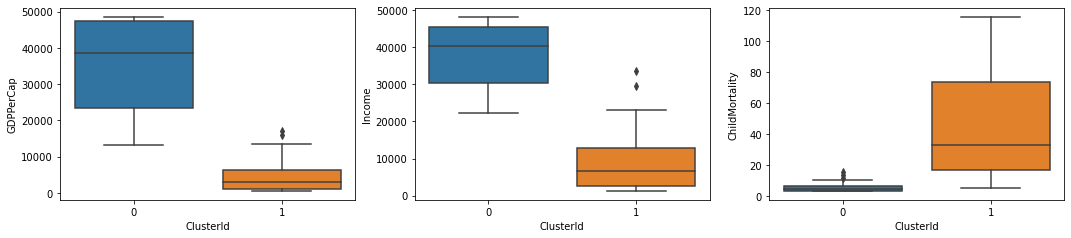

In [126]:
#Draw box plots to see the spread in each cluster against modeled columns
draw_box_clusters('ClusterId', comp_cols, df_socio_eco_cluster)

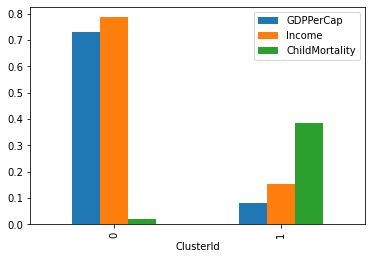

In [127]:
#Draw bar plots to see the mean values of modeled columns in each cluster using scaled data as 
# child mortality scale is very low and wouldn't be visible if drawn with GDPP
draw_bar_clusters('ClusterId', comp_cols, df_socio_eco_scaled_cluster)

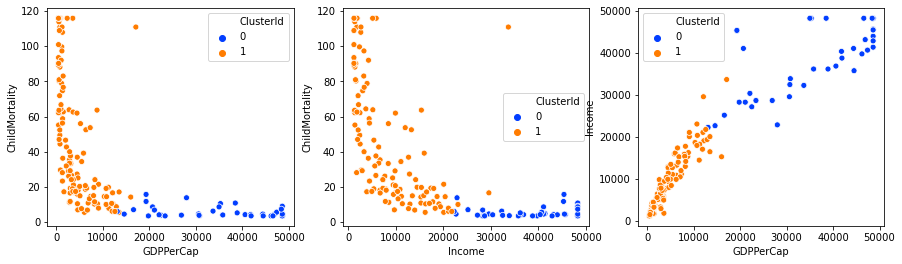

In [128]:
#Scatter plots to visualize the spread of 3 important columns
draw_scatter_clusters(df_socio_eco_cluster,k)

In [129]:
#Make copy of dataframe with unscaled data  
df_cluster = df.copy()

#Assign Cluster Id to a column with orginal unscaled data. 
df_cluster['ClusterId'] = kmeans.labels_

In [130]:
#Function to sort data of a particular cluster on gdgg, import and mortality
def sorted_cluster_data(df_cluster, cluster_id,order):
    return df_cluster[df_cluster.ClusterId == cluster_id].sort_values(
        by=['gdpp', 'child_mort', 'income'], ascending=order)[['country','gdpp', 'child_mort', 'income']]


In [131]:
#Sorting Order for Developed Countries
dev_order = [False, True, False]
#Sorting Order for Backward Countries
backward_order = [True, False, True]

#Select top 5 row from Cluster 0 with high gdp, income and low child mortality
print('Developed Cluster Countries:')
print(sorted_cluster_data(df_cluster,0,dev_order).head())

print()

#Select top 5 row from Cluster 1 with low gdp, income and high child mortality
print('Backward Cluster Countries:')
print(sorted_cluster_data(df_cluster,1,backward_order).head())

Developed Cluster Countries:
         country    gdpp  child_mort  income
91   Luxembourg   105000  2.8         91700 
114  Norway       87800   3.2         62300 
145  Switzerland  74600   4.5         55500 
123  Qatar        70300   9.0         125000
44   Denmark      58000   4.1         44000 

Backward Cluster Countries:
              country  gdpp  child_mort  income
26   Burundi           231   93.6        764   
88   Liberia           327   89.3        700   
37   Congo, Dem. Rep.  334   116.0       609   
112  Niger             348   123.0       814   
132  Sierra Leone      399   160.0       1220  


#### Clusters and their Properties

1. One cluster has high GDPs and Income with low child mortality. This indicates these are developed countries
2. The other cluster has low GDP and Income with high child mortality. These are backward countries, however since there are many csuch countries. it is not easy to m,ake a decision, hence let try with more number of clusters

#### Summary
One Cluster contains Socio economically rich and developed countries
Other Cluster contains backward countries with les GDP, Income and Exports. They struggle with low inflation and life expecancy. HELP organization should pick countries from this cluster to spend their funds. However since there are many such countries, we will try to divide the data with more clusters

### 5.1.3 Model with 3 clusters

In [132]:
# Build Model and fit it
k=3

#Instantiate the model
kmeans = KMeans(n_clusters=k, init=initialization, random_state=rs, n_init=n_init, n_jobs=n_jobs, algorithm=algo)

#Fit the model
kmeans.fit(df_socio_eco_scaled)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=15, n_jobs=4, precompute_distances='auto',
       random_state=1234, tol=0.0001, verbose=0)

In [133]:
#Assign Newly obtained Cluster Ids
df_socio_eco_scaled_cluster['ClusterId'] = kmeans.labels_
df_socio_eco_cluster['ClusterId'] = kmeans.labels_

#Print number of members in each cluster
df_socio_eco_scaled_cluster.ClusterId.value_counts()

1    82
2    48
0    37
Name: ClusterId, dtype: int64

### Cluster Profilling

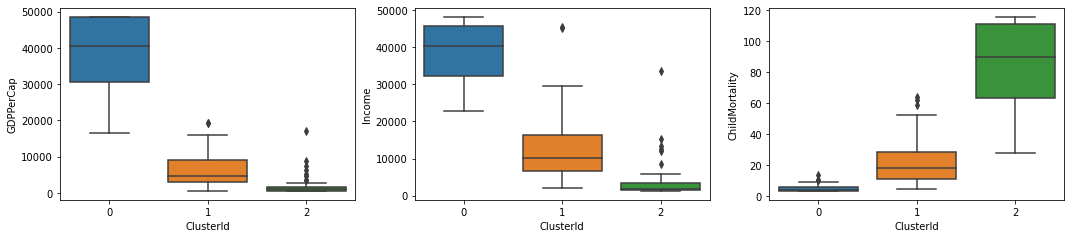

In [134]:
#Draw box plots to see the spread in each cluster against modeled columns
draw_box_clusters('ClusterId', comp_cols, df_socio_eco_cluster)

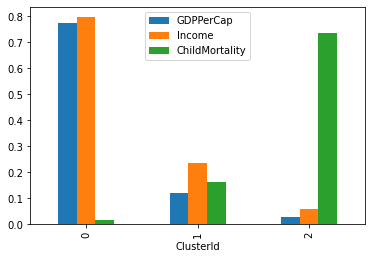

In [135]:
#Draw bar plots to see the mean values of modeled columns in each cluster using scaled data as 
# child mortality scale is very low and wouldn't be visible if drawn with GDPP
draw_bar_clusters('ClusterId', comp_cols, df_socio_eco_scaled_cluster)

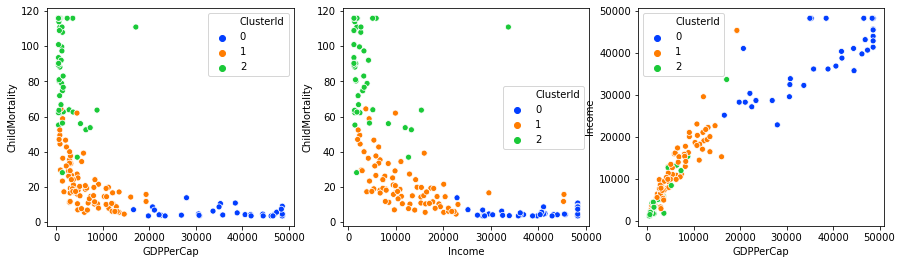

In [136]:
#Scatter plots to visualize the spread of 3 important columns
draw_scatter_clusters(df_socio_eco_cluster,k)

In [137]:
#Assign Cluster Id to a column with orginal unscaled data. 
df_cluster['ClusterId'] = kmeans.labels_

#Select top 5 row from Cluster 0 with high gdp, income and low child mortality
print('Developed Cluster Countries:')
print(sorted_cluster_data(df_cluster,0,dev_order).head())

print()

print('Moderately Developed Cluster Countries:')
print(sorted_cluster_data(df_cluster,1,dev_order).head())

print()

#Select top 5 row from Cluster 2 with low gdp, income and high child mortality
print('Backward Cluster Countries:')
print(sorted_cluster_data(df_cluster,2,backward_order).head())

Developed Cluster Countries:
         country    gdpp  child_mort  income
91   Luxembourg   105000  2.8         91700 
114  Norway       87800   3.2         62300 
145  Switzerland  74600   4.5         55500 
123  Qatar        70300   9.0         125000
44   Denmark      58000   4.1         44000 

Moderately Developed Cluster Countries:
          country   gdpp  child_mort  income
115  Oman          19300  11.7        45300 
128  Saudi Arabia  19300  15.7        45400 
13   Barbados      16000  14.2        15300 
51   Estonia       14600  4.5         22700 
41   Croatia       13500  5.5         20100 

Backward Cluster Countries:
              country  gdpp  child_mort  income
26   Burundi           231   93.6        764   
88   Liberia           327   89.3        700   
37   Congo, Dem. Rep.  334   116.0       609   
112  Niger             348   123.0       814   
132  Sierra Leone      399   160.0       1220  


#### Clusters and their Properties

1. Cluster 0 countries have very high GDPs and Income with low child mortality. This indicates these are top developed countries
2. Cluster 1 countries are in the middle with moderate GDP and Income, and Child mortality neither too low nor too high
3. Cluster 2 countries have very low GDPs and Income with high child mortality. This indicates these are backward countries.


#### Summary
Cluster 0 countries are already developed, Cluster 1 countries are developing and are mdoerately developed.

Cluster 2 is where HELP organization should spend their funds as they are struggling countries with low GDP and high Child Morttality

## 5.2 Hierarchical Clustering

In [138]:
#Define a function to apply hierarchical clustering by the given method on the given data
def clust_hier(df, method):
    mergings = linkage(df_socio_eco_scaled, method = method, metric='euclidean')
    plt.figure(figsize=(15,5))
    
    #Draw dendrogram
    dendrogram(mergings)
    plt.show()
    return mergings

### 5.2.1 Single Linkage

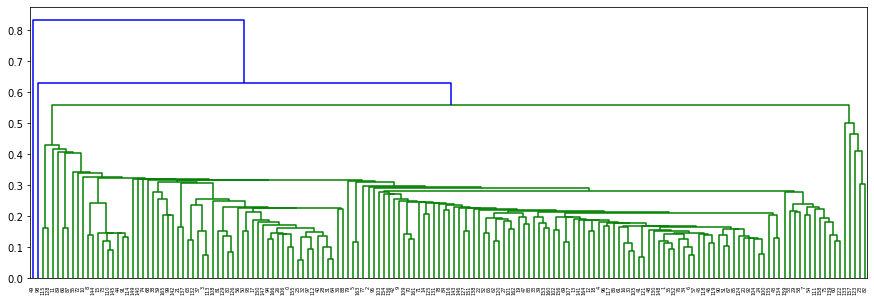

In [139]:
#Hierarchical Clustering with Single Linkage
mergings = clust_hier(df_socio_eco_scaled,'single')

#### As we can see, hierachical clustering with single linkage doesn't divide data into proper groups, hence we cannot use this linkage

### 5.2.2 Complete Linkage

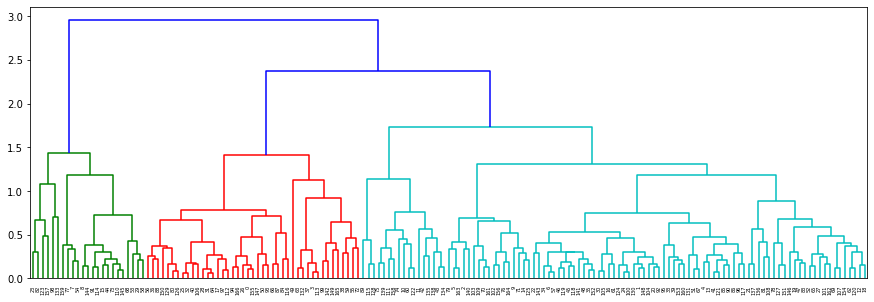

In [140]:
#Hierarchical Clustering with Complete Linkage
mergings = clust_hier(df_socio_eco_scaled,'complete')

#### With complete linkage, we can see clear clusters, even here, we can see there are 3 clusters clearly separated with different colours. This justifies the decision of using 3 clusters for Kmeans in section 5.1

### Hierarchical Clustering with 3 clusters.

In [141]:
#Cut the tree for getting 3 clusters
k=3
cluster_labels = cut_tree(mergings, n_clusters=k).reshape(-1,)

#Assign newly obtained Cluster Ids
df_socio_eco_scaled_cluster['ClusterId'] = cluster_labels
df_socio_eco_cluster['ClusterId'] = cluster_labels

#Get number of members in each cluser
df_socio_eco_scaled_cluster.ClusterId.value_counts()

1    101
0    43 
2    23 
Name: ClusterId, dtype: int64

### Cluster Profilling

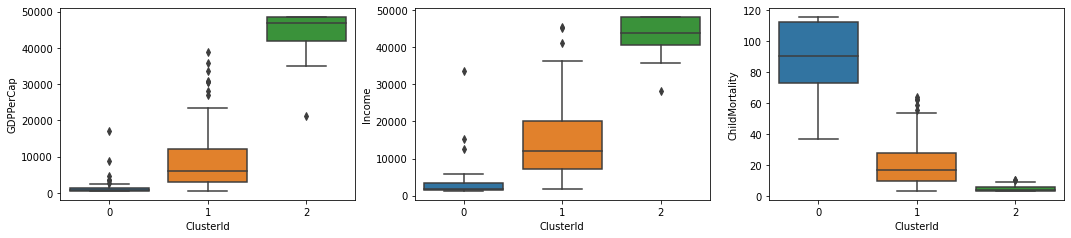

In [142]:
#Draw box plots to see the spread in each cluster against modeled columns
draw_box_clusters('ClusterId', comp_cols, df_socio_eco_cluster)

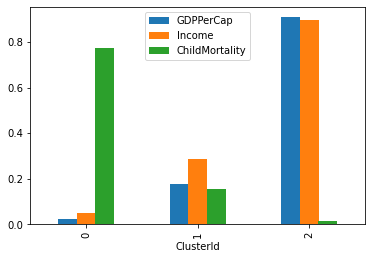

In [143]:
#Draw bar plots to see the mean values of modeled columns in each cluster using scaled data as 
# child mortality scale is very low and wouldn't be visible if drawn with GDPP
draw_bar_clusters('ClusterId', comp_cols, df_socio_eco_scaled_cluster)

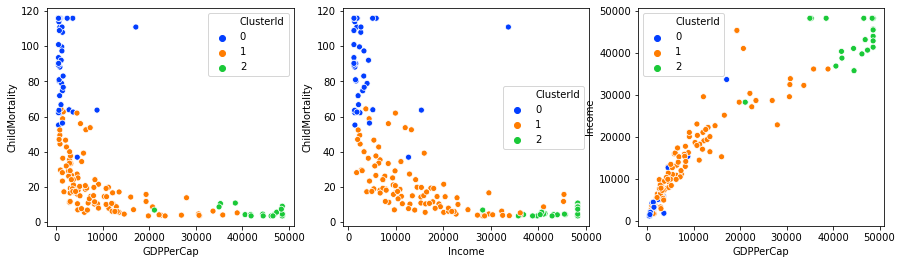

In [144]:
#Scatter plots to visualize the spread of 3 important columns
draw_scatter_clusters(df_socio_eco_cluster,k)

In [145]:
#Assign Cluster Id to a column with orginal unscaled data. 
df_cluster['ClusterId'] = cluster_labels

#Select top 5 row from Cluster 2 with high gdp, income and low child mortality
print('Developed Cluster Countries:')
print(sorted_cluster_data(df_cluster,2,dev_order).head())

print()

print('Moderately Developed Cluster Countries:')
print(sorted_cluster_data(df_cluster,1,dev_order).head())

print()

#Select top 5 row from Cluster 0 with low gdp, income and high child mortality
print('Backward Cluster Countries:')
print(sorted_cluster_data(df_cluster,0,backward_order).head())

Developed Cluster Countries:
         country    gdpp  child_mort  income
91   Luxembourg   105000  2.8         91700 
114  Norway       87800   3.2         62300 
145  Switzerland  74600   4.5         55500 
123  Qatar        70300   9.0         125000
44   Denmark      58000   4.1         44000 

Moderately Developed Cluster Countries:
            country   gdpp  child_mort  income
158  United Kingdom  38900  5.2         36200 
75   Italy           35800  4.0         36200 
111  New Zealand     33700  6.2         32300 
42   Cyprus          30800  3.6         33900 
139  Spain           30700  3.8         32500 

Backward Cluster Countries:
              country  gdpp  child_mort  income
26   Burundi           231   93.6        764   
88   Liberia           327   89.3        700   
37   Congo, Dem. Rep.  334   116.0       609   
112  Niger             348   123.0       814   
132  Sierra Leone      399   160.0       1220  


### Observations from hierarchical clustering

#### We can observe similar results as KMeans. One of the 3 clusters (Cluster 2) are developed, one of them (Cluster 1) is moderately developed. The other cluster is backward countries. Here it is Cluster 0 on which HELP organization should spend their funds.

## 6. Final Model

### 6.1 KMean with 3 clusters 

In [146]:
#Assign Cluster Id to a column with orginal unscaled data, 
# Here, kmeans.labels_ refer to labels assigned by KMeans clustering with 3 clusters
df_cluster['ClusterId'] = kmeans.labels_

#Select top 10 row from Cluster 2 with low gdp, income and high child mortality
sorted_cluster_data(df_cluster, 2, backward_order)['country'].head(10)

26     Burundi                 
88     Liberia                 
37     Congo, Dem. Rep.        
112    Niger                   
132    Sierra Leone            
93     Madagascar              
106    Mozambique              
31     Central African Republic
94     Malawi                  
50     Eritrea                 
Name: country, dtype: object

#### As there are 48 countries in cluster 2 on which HELP Organization should spend their funds, we have selected top 7 countries among these.

### 6.2 Hierarchical with 3 clusters (To Compare)

In [147]:
#Assign Cluster Id to a column with orginal unscaled data. 
# Here, cluster_labels refers to labels assigned by hierarchical clustering with 3 clusters 
df_cluster['ClusterId'] = cluster_labels

#Select top 10 rows from Cluster 2 with low gdp, income and high child mortality
sorted_cluster_data(df_cluster, 0, backward_order)['country'].head(10)

26     Burundi                 
88     Liberia                 
37     Congo, Dem. Rep.        
112    Niger                   
132    Sierra Leone            
93     Madagascar              
106    Mozambique              
31     Central African Republic
94     Malawi                  
50     Eritrea                 
Name: country, dtype: object

#### Same countries are selected by both KMeans and hierachical clustering. 

## 7. Summary

#### These are the final list of countries we propose HELP organization to spend their funds:
1. Burundi                 
2. Liberia                 
3. Congo, Dem. Rep.        
4. Niger                   
5. Sierra Leone            
6. Madagascar              
7. Mozambique         
8. Central African Republic
9. Malawi
10. Eritrea